### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### Setup

In [2]:
# === Constantes
FILE_NAME = 'historico.xlsx'

### Caregando dados

In [3]:
# === Dataframe
df = pd.read_excel(FILE_NAME)
# Limpando colunas com espaço
df.columns = df.columns.str.replace(' ', '')
# Filtrando dados com erro de digitação
filtro_media_invalida = df['Média'] > 10
print (f"Eliminando {filtro_media_invalida.sum()} registros com média invalida (superior a 10)")
df = df[~filtro_media_invalida]

# === Sub dataframes importantes
# Alunos reprovados (Média < 5.0)
df_reprovados = df[df['Média'] < 5.0]

# === Valores importantes
# Total de alunos no dataset
total_alunos = len(df['Matrícula'].unique())

Eliminando 644 registros com média invalida (superior a 10)


---

### Ex 1 

Qual é, percentualmente, a taxa de alunos que reprovam em uma disciplina pela 1º vez? E a mesma disciplina pela 2ª vez? 3ª? 4ª? 5ª?...

In [4]:
# Contabilizando o total de reprovacoes por disciplina, por aluno
df_contagem_reprovacoes = df_reprovados.groupby(['Matrícula', 'Disciplina'])['Matrícula'].count()
for i in range(1,6):
    # Separa as ocorrencias de i ou mais reprovaçoes na mesma materia por um dado aluno
    reprovados_i_vezes = df_contagem_reprovacoes[df_contagem_reprovacoes >= i]
    # Extrai a matriculas dos alunos, eliminando duplicados
    matriculas = reprovados_i_vezes.index.get_level_values('Matrícula').unique()
    # Conta o numero de matriculas
    numero_de_alunos = len(matriculas)
    # Exibindo o resultado
    print(f'{numero_de_alunos:>3}/{total_alunos} ({numero_de_alunos/total_alunos*100:>2.0f}%) dos alunos ja reprovaram ao menos {i} vez(es) em uma mesma disciplina')



827/1192 (69%) dos alunos ja reprovaram ao menos 1 vez(es) em uma mesma disciplina
441/1192 (37%) dos alunos ja reprovaram ao menos 2 vez(es) em uma mesma disciplina
239/1192 (20%) dos alunos ja reprovaram ao menos 3 vez(es) em uma mesma disciplina
107/1192 ( 9%) dos alunos ja reprovaram ao menos 4 vez(es) em uma mesma disciplina
 50/1192 ( 4%) dos alunos ja reprovaram ao menos 5 vez(es) em uma mesma disciplina


---

### Ex 2

Qual disciplina reprova mais? Qual reprova menos?

In [5]:
indice_reprovacao = df_reprovados['Disciplina'].value_counts(normalize=True, sort=True, ascending=False)*100
maior, menor = indice_reprovacao.iloc[[0,-1]].items()

print("Disciplina | Indice de reprovação (%)")
print(f"{maior[0]:^10d} | {maior[1]:^22.4f}")
print(f"{menor[0]:^10d} | {menor[1]:^22.4f}")

Disciplina | Indice de reprovação (%)
  41082    |         9.1296        
  56481    |         0.0152        


O indice de reprovação calculado acima indica, do total reprovações, quantos % são relativos a determinada disciplina.

- A disciplina responsável pelo maior número de reprovações (9.1296%) é a de código 41082.
- A disciplina responsável pelo menor número de reprovações (0.0152%) é a de código 56481.

---

### Ex 3

Qual é a relação entre a nota obtida na reprovação e o sucesso/fracasso da próxima vez que o aluno faz a mesma disciplina?

In [6]:
# df_reprovados[['Matrícula','Semestre', 'Ano']]
df_por_aluno = df.groupby(['Matrícula', 'Disciplina'])

contagem = {
    'sucesso': 0,
    'fracasso': 0
}
for (matricula, disciplina), df_notas in tqdm(df_por_aluno):
    df_notas.sort_values(['Ano','Semestre'], inplace=True)
    df_notas['resultado_seguinte'] = df_notas.shift(-1)['Média']
    contagem['sucesso'] += (df_notas['resultado_seguinte'] >= 5).sum() # Reprovou e passou no semestre seguinte
    contagem['fracasso'] += (df_notas['resultado_seguinte'] < 5).sum() # Reprovou e reprovou novamente no semestre seguinte
    # Casos em que não houve uma proxima vez em que o aluno fez a materia serao desconsiderados por serem nan

100%|██████████| 25490/25490 [00:22<00:00, 1121.21it/s]


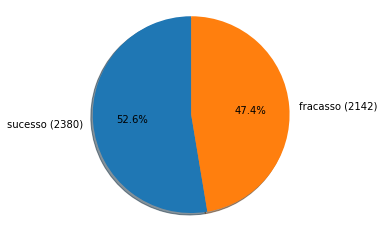

In [7]:
fig1, ax1 = plt.subplots()

labels = [f'{label} ({valor})' for label, valor in contagem.items()]

ax1.pie(contagem.values(), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Pelo grafico podemos notar que pouco mais de metade das vezes (52.6%) em que um aluno reprova em uma disciplina, este é aprovado na próxima tentativa.